# Calvin's Changes to eventually add to compiled_submission
Putting them here to avoid merge conflicts and stuff from editing the same file

In [28]:
# These are already in the doc, don't add them again
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

current_dir = os.getcwd()

## \#\# INSERT IN DATA COLLECTION SECTION \#\#

### ESRI US Counties Geospatial Dataset
Since large amounts of our environmental data are aggregated by county, as well as county serving as a division that is neither too narrow or too wide for analysis, we'd like to be able to merge these datasets, aggregating by county. The issue that arises is that even though most environmental datasets are already sorted by county, the information they use to identify the counties are not consistent. There are a wide variety of ways to identify the county location of a particular entry: For US states, this could be the state's full name, two-letter postal abbreviation, or FIPS code. For US counties, this could be the county's full name or FIPS code, both of which also depend on the state (for example, many states have a "Washington County", and each county's FIPS code is particular to the state it lies in). As such, there are a lot of different combinations of these representations that can occur in these datasets, and sometimes these may not overlap enough to create a meaningful merge. This is where a common county information dataset comes into play. This information comes from the Environmental Systems Research Institute, and contains most of the different representations (State FIPS, County FIPS, State Name, County Name), and can serve as a common ground for merging datasets. 

The other benefit of this is that it includes *shapefile* data, which creates a geospatial representation of the counties. This representation allows for identifying counties that particular longitude and latitude coordinates lie within, which serves as a useful tool for translating the BBS birding routes, which are specified by longitude and latitude, to counties, to be able to match environmental data to bird data.

Download this dataset which is highlighted at the following link: [ESRI County Shapefile Forum](https://community.esri.com/t5/arcgis-enterprise-portal-questions/where-can-i-find-a-shapefile-with-all-us-counties/td-p/307592#:~:text=Hi%20Robert%2C,UScounties.zip), provided by an anonymous user in response to another user searching for such a dataset, having retrieved it from ESRI.

### MetricT: Tennessee Politics Geospatial Dataset
The other thing that we'd like to be able to do is create geographical maps of county-aggregated data that present meaningful visualizations of the data, coloring each county by some metric to show patterns and distributions. While the ESRI counties dataset contains geospatial shapefile data, it maintains the true geographic positions and scales of the country, including Alaska and Hawaii. While this is useful for pinpointing longitude and latitude and other processing applications, it creates issues for visualization. In their actual locations, Alaska appears disproportionately large due to its vast size and the distortion effects of map projection, while Hawaii appears small and distant. This configuration results in a map where the contiguous United States is reduced in size and shifted, creating an unbalanced visual with excessive empty space where Canada and the Pacific Ocean are typically located. Such a map can be difficult to interpret and aesthetically unappealing. This dataset, created by a GitHub user named MetricT, includes county shapefiles that reposition and rescale Alaska and Hawaii to be conveniently visible below the map of the contiguous United States. This adjustment is a common practice in many published maps to improve visual clarity and coherence. Therefore, the adjusted dataset is designed for visualizations that focus on county-level data, ensuring a more cohesive and accessible representation of all U.S. counties. However, it is important to note that for applications requiring precise geographic data, such as the mapping of routes using specific latitude and longitude coordinates, the ESRI counties dataset should be used to ensure accuracy in spatial relationships and geographic positioning.

Download this dataset (us_county.tar.xz) from this GitHub repository at this link: [TN_Politics GitHub](https://github.com/MetricT/TN_Politics/blob/master/shapefiles/us_county.tar.xz).

### US Census Dataset on County Land Areas
The total land area of each county is a useful metric to use for processing other data. The United States Census Bureau released data on several demographic and geographical indicators in 2011 following the 2010 Census, and county land areas in square miles is included.

Download this dataset (LND01.xls) from the Census Bureau's website: [USA Counties 2011](https://www.census.gov/library/publications/2011/compendia/usa-counties-2011.html#:~:text=%5B8.8%20MB%5D-,Land%20Area,-LND01.xls%20%5B1.5).

## \#\# INSERT IN DATA PROCESSING SECTION \#\#

### Processing National Center for Health Statistics Urban-Rural Classification (By County)

Let's now process the dataset from the CDC NCHS that classifies counties by their level of urbanization. Let's remind ourselves of the scale that they use.

1 = Large central metropolitan (Big cities)

2 = Large fringe metropolitan

3 = Medium metropolitan

4 = Small metropolitan

5 = Micropolitan

6 = Non-core (Rural)

In [4]:
urban_index = pd.read_excel(os.path.join(current_dir, "..", "Data", "NCHSURCodes2013.xlsx"))
urban_index = urban_index[["FIPS code", "State Abr.", "County name", "2013 code"]].rename(columns={"FIPS code": "FIPS", "State Abr.": "STATECODE", "County name": "COUNTY", "2013 code": "URBAN_RURAL_SCORE"})

# Add label for each index for readability
label_map = {
    1: "Large central metropolitan",
    2: "Large fringe metropolitan",
    3: "Medium metropolitan",
    4: "Small metropolitan",
    5: "Micropolitan",
    6: "Non-core"
}

urban_index["METRO_LEVEL"] = urban_index["URBAN_RURAL_SCORE"].map(label_map)
# FIPS codes are treated as integers; convert them to strings and pad left with zeroes until they take up 5 characters
urban_index["FIPS"] = urban_index["FIPS"].astype(str).str.zfill(5)

# Save to csv to avoid having to process again
urban_index.to_csv(os.path.join(current_dir, "..", "Data", "metro.csv"), index=False)

Here's a glimpse at this dataset.

In [6]:
urban_index.head(5)

,FIPS,STATECODE,COUNTY,URBAN_RURAL_SCORE,METRO_LEVEL
0,01001,AL,Autauga County,3,Medium metropolitan
1,01003,AL,Baldwin County,4,Small metropolitan
2,01005,AL,Barbour County,6,Non-core
3,01007,AL,Bibb County,2,Large fringe metropolitan
4,01009,AL,Blount County,2,Large fringe metropolitan


### Processing Open Energy Data Initiative: City and County Commercial Building Inventories

Let's now take a look at the DoE's dataset on commercial building inventories. Once again, **don't run this code more than once.** The data used in this section involves over 2.2 million building entries, so processing takes several minutes and a powerful computer. The data is saved to a set of much more concise csv files that can be re-read in to avoid this overhead. 

First, we need a function that will translate a state's name to its two-letter postal code, which will assist in joining it with other data. 

In [7]:
def translate_state(state_name):
    state_abbreviations = {
        'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY'
    }

    return state_abbreviations[state_name]

Now we can get to processing.

In [9]:
# This section will do all of the processing and save to csv, so it will be quite long.

# Read in regional data from all excel files
west_df = pd.read_excel(os.path.join(current_dir, '..', 'Data', 'Buildings', 'West.xlsb'), sheet_name="County")
midwest_df = pd.read_excel(os.path.join(current_dir, '..', 'Data', 'Buildings', 'Midwest.xlsb'), sheet_name="County")
southatlantic_df = pd.read_excel(os.path.join(current_dir, '..', 'Data', 'Buildings', 'SouthAtlantic.xlsb'), sheet_name="County")
southcentral_df = pd.read_excel(os.path.join(current_dir, '..', 'Data', 'Buildings', 'SouthCentral.xlsb'), sheet_name="County")
northeast_df = pd.read_excel(os.path.join(current_dir, '..', 'Data', 'Buildings', 'Northeast.xlsb'), sheet_name="County")

# Join all regional datasets to a combined national dataset
buildings = pd.concat([west_df, midwest_df, southatlantic_df, southcentral_df, northeast_df])

# Group by county and sum the number of buildings in each county
grouped = buildings[["statecode", "countyname", "bldg_count"]].groupby(["statecode", "countyname"]).agg("sum").reset_index()

# The data also contains a column specifying what each building's reported use is (such as Health Care, Office, Retail, etc.)
# Group by county, but also by use, and for each county, sum number and area of buildings of each type
grouped_use = buildings[["statecode", "countyname", "reported_propertytype", "bldg_count", "area_sum"]].groupby(["statecode", "countyname", "reported_propertytype"]).agg("sum").reset_index()

# Also create a dataset summing the total area of buildings in each county
grouped_area = buildings[["statecode", "countyname", "area_sum"]].groupby(["statecode", "countyname"]).agg("sum").reset_index()

# Use land area dataset to create a metric for building density
# SEE NOTE 1 BELOW FOR MORE DETAILS
land_df = pd.read_excel(os.path.join(current_dir, '..', 'Data', 'LandArea.xls'), dtype=str)
land_df = land_df[["STCOU", "LND110210D"]] # LND110210D is Land Area of counties in 2010 (not including water), STCOU is state fips and county fips
land_df["STATE_FIPS"] = land_df["STCOU"].str[:-3] # Extract just state fips
land_df["CNTY_FIPS"] = land_df["STCOU"].str[-3:] # Extract just county fips

# Pull ESRI county info dataset to serve as a middle ground for data merging
counties = gpd.read_file(os.path.join(current_dir, '..', 'SharedData', 'UScounties', 'UScounties.shp')).drop("geometry", axis=1) # County dataset

# Connect land area data to county information, make sure the merge is 1 to 1.
merged1 = pd.merge(land_df, counties, on=["STATE_FIPS", "CNTY_FIPS"], how="inner", validate="1:1")
# Use above function to create column detailing state postal codes
merged1['statecode'] = merged1['STATE_NAME'].apply(translate_state)
merged1 = merged1.rename(columns={"NAME": "COUNTY"})
grouped_area = grouped_area.rename(columns={"countyname": "COUNTY"})
# First merge on state code, since these are consistent
merged_df = pd.merge(merged1, grouped_area, on=['statecode'], suffixes=('_df1', '_df2'))
# Counties in the building dataset contain longer names with suffixes such as "County" and "Parish" based on their names;
# Counties in the land area dataset do not include these suffixes
# Luckily, there is consistency by comparing the land area dataset's full county name to the start of the building
# dataset's county name, since the additional characters are suffixes and do not affect the beginning.
def merge_county(df1_county, df2_county):
    return df2_county.startswith(df1_county)
# Merge on this function
merged_df = merged_df[merged_df.apply(lambda x: merge_county(x['COUNTY_df1'], x['COUNTY_df2']), axis=1)]

# Now we can divide building area by total land area for each county to get a building density metric
merged_df["bldg_area_per_sq_mile"] = merged_df["area_sum"] / merged_df["LND110210D"].astype(float)

# Keep only useful columns; rename as necessary
adjusted_grouped_area = merged_df[["STATE_NAME", "statecode", "STATE_FIPS", "COUNTY_df1", "COUNTY_df2", "CNTY_FIPS", "area_sum", "LND110210D", "bldg_area_per_sq_mile"]]
adjusted_grouped_area = adjusted_grouped_area.rename(columns={"LND110210D": "LandAreaSqMiles", "COUNTY_df1":"COUNTY", "statecode":"STATECODE", "area_sum":"total_bldg_area", "COUNTY_df2":"FORMAL_COUNTY"})

# Save these datasets to csv
grouped.to_csv(os.path.join(current_dir, '..', 'SharedData', 'County_Building_Counts.csv'), index=False)
grouped_area.to_csv(os.path.join(current_dir, '..', 'SharedData', 'County_Building_Areas.csv'), index=False)
adjusted_grouped_area.to_csv(os.path.join(current_dir, '..', 'SharedData', 'County_Building_Areas_Adjusted.csv'), index=False)

# SEE NOTE 2
# Pivot dataset by building type
grouped_use2 = grouped_use.pivot(columns="reported_propertytype", index=["statecode", "countyname"], values=["bldg_count", "area_sum"])
# Flatten multi-index columns
grouped_use2.columns = grouped_use2.columns.map('_'.join).str.strip('_')
grouped_use2 = grouped_use2.reset_index()
# Fill NAs with 0 (These are counties with no buildings of certain types)
grouped_use2 = grouped_use2.fillna(0)
# Lose these building types; a very small number of counties have anything at all in these categories
grouped_use2 = grouped_use2.drop(columns=["bldg_count_General Retail", "area_sum_General Retail", "bldg_count_Unknown", "area_sum_Unknown"])
# Rename columns to remove spaces and hypens
grouped_use2 = grouped_use2.rename(columns={
    "bldg_count_Health Care": "bldg_count_Healthcare", 
    "area_sum_Health Care": "area_sum_Healthcare", 
    "bldg_count_Multi-Family": "bldg_count_Multifamily",
    "area_sum_Multi-Family": "area_sum_Multifamily",
    "bldg_count_Sports & Entertainment": "bldg_count_Entertainment",
    "area_sum_Sports & Entertainment": "area_sum_Entertainment"
    })
# Save this pivoted dataset to CSV
grouped_use2.to_csv(os.path.join(current_dir, '..', 'SharedData', 'County_Building_Counts_By_Type.csv'), index=False)

# Finally, we can opt to create a dataset that contains all of these findings.
master = adjusted_grouped_area.merge(grouped, how="inner", right_on=["statecode", "countyname"], left_on=["STATECODE", "FORMAL_COUNTY"])
master = master.merge(grouped_use2, how="inner", on=["statecode", "countyname"])
master = master.drop(["STATECODE", "FORMAL_COUNTY"], axis=1)
# Rearrange columns
cols = ["STATE_NAME", "statecode", "STATE_FIPS", "COUNTY", "countyname", "CNTY_FIPS", "bldg_count"] + master.columns.tolist()[4:7] + master.columns.tolist()[10:]
master = master[cols]
master = master.rename(columns={"statecode": "STATECODE", "countyname": "FORMAL_COUNTY"})
joined_fips_codes = master["STATE_FIPS"] + master["CNTY_FIPS"]
master.insert(6, column="FIPS", value=joined_fips_codes)
master.to_csv(os.path.join(current_dir, '..', 'SharedData', 'County_Buildings_MASTER.csv'), index=False)
# Display first ten entries in the master dataset
master.head(10)

,STATE_NAME,STATECODE,STATE_FIPS,COUNTY,FORMAL_COUNTY,CNTY_FIPS,FIPS,bldg_count,total_bldg_area,LandAreaSqMiles,...,bldg_count_Entertainment,area_sum_Flex,area_sum_Healthcare,area_sum_Hospitality,area_sum_Industrial,area_sum_Multifamily,area_sum_Office,area_sum_Retail,area_sum_Specialty,area_sum_Entertainment
0,Alabama,AL,01,Autauga,Autauga County,001,01001,348,6993000,594.44,...,0.0,26900.0,9200.0,216300.0,2093700.0,1805400.0,453100.0,2223200.0,165200.0,0.0
1,Alabama,AL,01,Baldwin,Baldwin County,003,01003,3370,60335200,1589.78,...,13.0,724700.0,1414900.0,5791400.0,9663000.0,16491000.0,4850500.0,16964900.0,4044600.0,390200.0
2,Alabama,AL,01,Barbour,Barbour County,005,01005,183,6098300,884.88,...,2.0,0.0,0.0,64900.0,1786900.0,2974500.0,111500.0,1068400.0,86900.0,5200.0
3,Alabama,AL,01,Bibb,Bibb County,007,01007,97,1386100,622.58,...,0.0,19800.0,0.0,0.0,284200.0,437300.0,97100.0,526100.0,21600.0,0.0
4,Alabama,AL,01,Blount,Blount County,009,01009,266,2821200,644.78,...,3.0,31500.0,5400.0,0.0,794500.0,456800.0,152900.0,1221300.0,84300.0,74500.0
5,Alabama,AL,01,Bullock,Bullock County,011,01011,44,553000,622.81,...,0.0,0.0,0.0,0.0,229600.0,130300.0,47300.0,139500.0,6300.0,0.0
6,Alabama,AL,01,Butler,Butler County,013,01013,188,2858700,776.83,...,0.0,23000.0,85500.0,103800.0,894000.0,598200.0,89700.0,1018000.0,46500.0,0.0
7,Alabama,AL,01,Calhoun,Calhoun County,015,01015,1313,23999100,605.87,...,6.0,286300.0,241900.0,439000.0,6610000.0,4685100.0,2005600.0,8181100.0,1515000.0,35100.0
8,Alabama,AL,01,Chambers,Chambers County,017,01017,210,6910000,596.53,...,0.0,37300.0,32000.0,68300.0,3436100.0,1317700.0,603700.0,1251200.0,163700.0,0.0
9,Alabama,AL,01,Cherokee,Cherokee County,019,01019,136,1849000,553.7,...,0.0,5000.0,50000.0,54000.0,138700.0,394000.0,77500.0,1036500.0,93300.0,0.0


#### Notes on this processing
Due to the linear nature of this data processing script, all detailed notes will be included here, rather than throughout the code.
1. The purpose of using county land area here is to control for differently sized counties. Some counties are very large, so they have more room for more buildings, while some are very small and do not. Thus, using building area data without considering county land area could lead to confounding factors. As such, we divide each county's building area by its total land area, to get a metric for the *density* of buildings in the county. 
2. Another way to format this data is to create a separate column detailing the building counts and area for each building type. This will also allow for data for each building type to be used as a separate predictor in modeling, which could potentially show whether particular building types have better or worse effects on bird populations.

As we can see above, we've got a lot of information now on commercial buildings to use in our predictions!

## \#\# INSERT IN DATA VISUALIZATION SECTION \#\#

Let's go ahead and visualize some of our predictors from the various datasets on a map of the United States to see if we can see any patterns or make any preliminary hypotheses. We'll start with the forest data.

Let's read in the MetricT county shapefile data to create our visualizations.

In [13]:
counties = gpd.read_file(os.path.join(current_dir, '..', 'SharedData', 'Counties2', 'us_county.shp')).rename(columns={"GEOID": "FIPS"})
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,FIPS,NAME,LSAD,ALAND,AWATER,id,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,6.393875e+08,69473325.0,1,"POLYGON ((959182.740 -821711.187, 959268.612 -..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,7.504394e+08,4829777.0,2,"POLYGON ((1350485.716 -619831.406, 1350606.534..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1.103572e+09,13943044.0,3,"POLYGON ((1155226.654 -790469.014, 1155326.223..."
3,21,065,00516879,0500000US21065,21065,Estill,06,6.555099e+08,6516335.0,4,"POLYGON ((1390075.380 -684612.798, 1390215.039..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,9.027272e+08,7182793.0,5,"POLYGON ((1386431.679 -594472.514, 1386496.220..."


We'll use the 50% threshold for the forest data for these visualizations. 

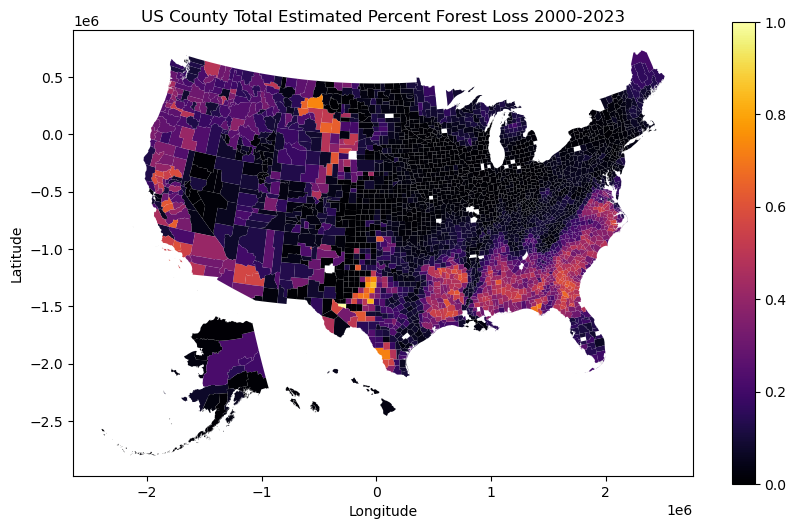

In [14]:
# Bring in forest data
forest = pd.read_csv(os.path.join(current_dir, "..", "Data", "Deforestation", "Total_Forest_Loss_Threshold_50.csv"), dtype={'FIPS': str})

merged = counties.merge(forest, how="inner", left_on="FIPS", right_on="FIPS")

column_to_plot = 'percent_lost'

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged.plot(column=column_to_plot, cmap='inferno', linewidth=0.01, ax=ax, edgecolor='0.8', legend=True)
plt.title('US County Total Estimated Percent Forest Loss 2000-2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

As we can see, there seems to be the most forest loss in the Southeastern US, the West Coast, and various parts of Texas, Montana, and Wyoming areas. However, there is one factor of this dataset that we did not consider before creating this map. Many counties in the US did not begin with much forest at all, mostly in counties in arid or cold biomes, such as grasslands and desert. Consider a county who reports losing 2 hectares of forest. The percentage of forest lost changes dramatically based on whether this county started with 2,000 hectares of forest, or 3 hectares of forest. As such, counties like these who started with little forest and lost "most" of their forest are potentially confounding this visualization, because while it is true that these counties did lose a large percentage of their forests, they are not our primary focus with this data. To investigate this further, let's visualize the forest density across the US.

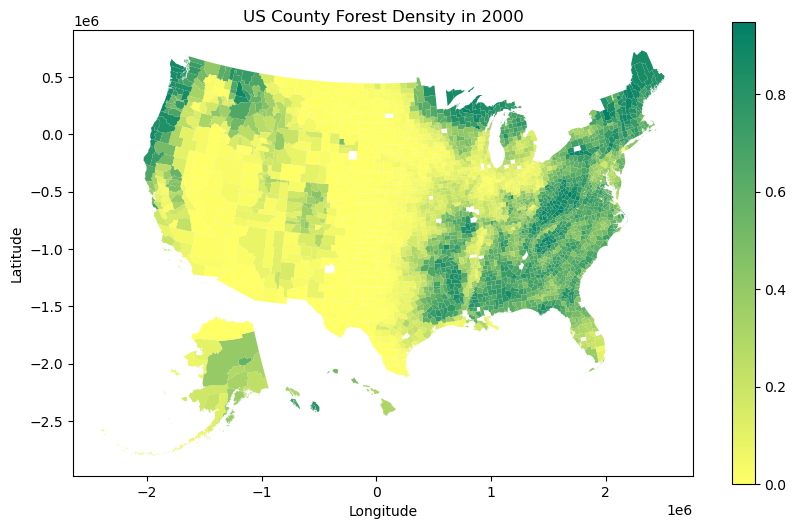

In [15]:
# This will produce a percent coverage value based on how much of the total area of the county was covered in forest in 2000.
merged["Coverage"] = merged["extent_2000_ha"] / merged["area_ha"]

column_to_plot = 'Coverage'

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged.plot(column=column_to_plot, cmap='summer_r', linewidth=0.01, ax=ax, edgecolor='0.8', legend=True)
plt.title('US County Forest Density in 2000')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

This is very informative. Many counties, particularly those in the Great Plains and those in the Mojave desert, did not begin with much forest at all. We don't want to fully ignore these counties, but perhaps we can scale them in importance by making those counties with higher forest density show a higher loss value than those with lower forest density.

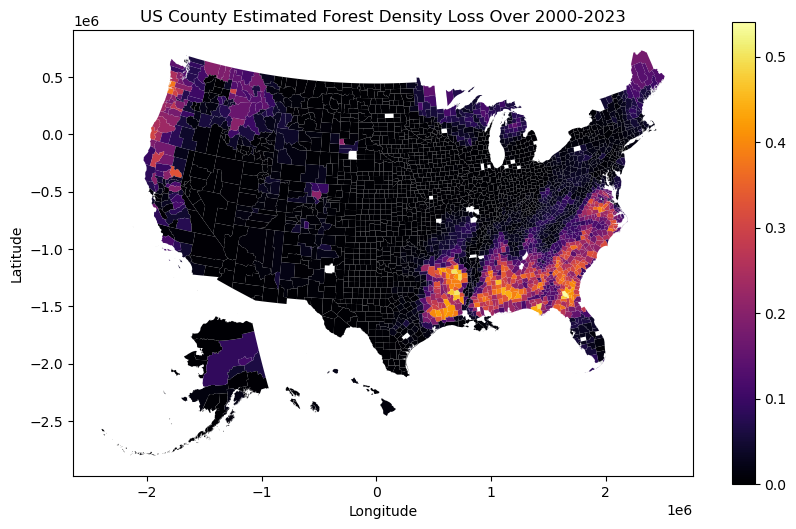

In [16]:
# Scale loss by forest density calculated above
merged["Scaled_Loss"] = merged["Coverage"] * merged["percent_lost"]

column_to_plot = 'Scaled_Loss'

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged.plot(column=column_to_plot, cmap='inferno', linewidth=0.01, ax=ax, edgecolor='0.8', legend=True)
plt.title('US County Estimated Forest Density Loss Over 2000-2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Wow! This scaling shows a much more systematic map; it appears that the southeastern US and the northern West Coast experienced the most intense forest loss, having started with ample forest coverage, while those counties with lower forest coverage show much less significant loss. 

Let's now visualize the urban index data to find patterns there.

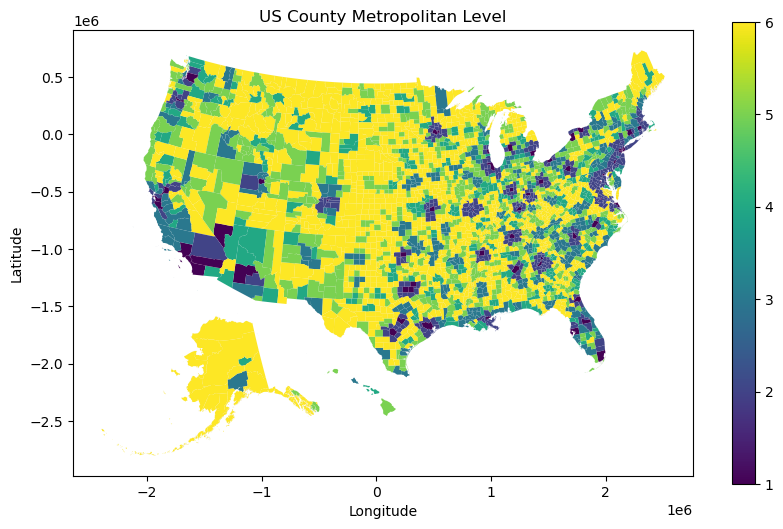

In [20]:
urban_index_data = pd.read_csv(os.path.join(current_dir, "..", "Data", "metro.csv"), dtype={"FIPS": str})

merged = counties.merge(urban_index_data, how="inner", left_on="FIPS", right_on="FIPS")

column_to_plot = 'URBAN_RURAL_SCORE'

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged.plot(column=column_to_plot, cmap='viridis', linewidth=0.01, ax=ax, edgecolor='0.8', legend=True)
plt.title('US County Metropolitan Level')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

As expected, the counties with the highest level of urbanization (lowest index) are those that contain or lie near large metropolitan centers in the USA. If you wanted, you could probably figure out the metropolis represented by each purple cluster of counties; you can certainly see Los Angeles, Chicago, Atlanta, and the Boston-Washington corridor. 

Let us now visualize the commercial building data.

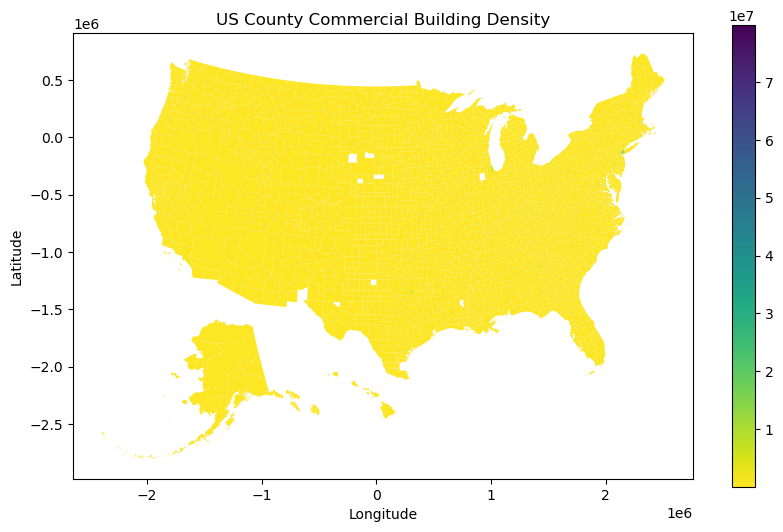

In [22]:
building_density = pd.read_csv(os.path.join(current_dir, "..", "SharedData", "County_Building_Areas_Adjusted.csv"), dtype={"CNTY_FIPS": str, "STATE_FIPS": str})
# Create combined FIPS code
building_density["FIPS"] = building_density["STATE_FIPS"] + building_density["CNTY_FIPS"]

merged = counties.merge(building_density, how="inner", left_on="FIPS", right_on="FIPS")
# merged['log_density'] = np.log(merged['bldg_area_per_sq_mile']) # Log transformed because New York County (manhattan) is vastly denser than all other counties

column_to_plot = 'bldg_area_per_sq_mile'

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged.plot(column=column_to_plot, cmap='viridis_r', linewidth=0.01, ax=ax, edgecolor='0.8', legend=True)
plt.title('US County Commercial Building Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Well, that's not very informative. What's causing this? If you look very closely at the northern East Coast, you may see a single speck of purple and green. This is New York City, whose building density is extremely high, and very disproportionate to the rest of the country. 

Looks like we'll need to apply a transformation to this value to create a meaningful visualization! Let's log transform the values. 

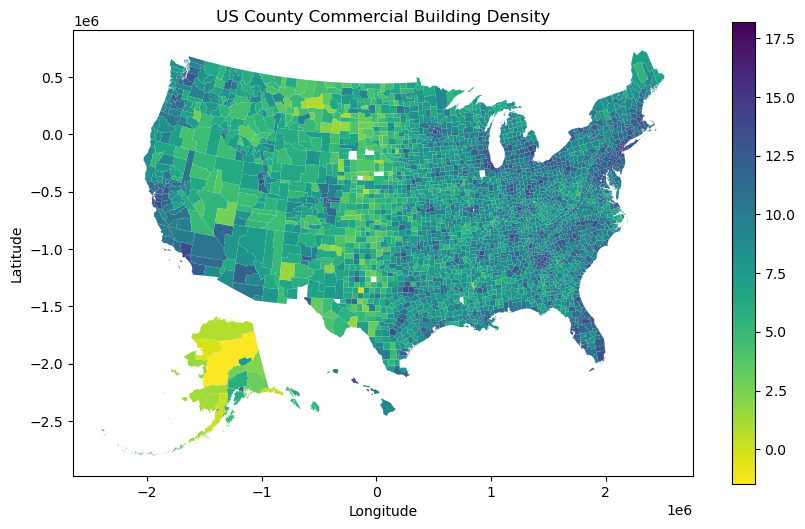

In [26]:
merged['log_density'] = np.log(merged['bldg_area_per_sq_mile']) # Log transformed because New York County (manhattan) is vastly denser than all other counties

column_to_plot = 'log_density'

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged.plot(column=column_to_plot, cmap='viridis_r', linewidth=0.01, ax=ax, edgecolor='0.8', legend=True)
plt.title('US County Commercial Building Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

That's much better. Once again, you may be able to see some of the large metropolitan areas in the United States in the darker areas.

Urban index and building density may be correlated, since they deal with similar ideas. Let's see if that's true!

Slope: -1.061270320885903
Intercept: 13.40677650563575


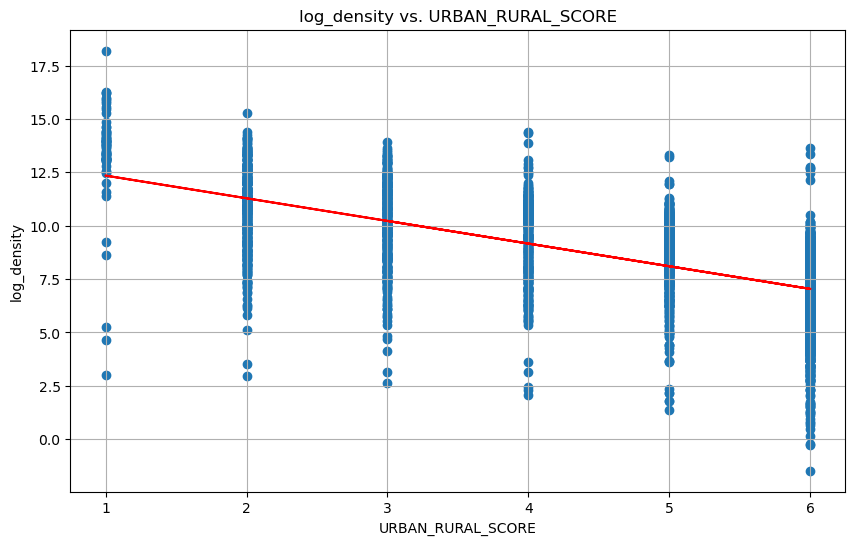

In [30]:
merged = urban_index_data.merge(building_density, how="inner", left_on="FIPS", right_on="FIPS")

# Create log transform again
merged['log_density'] = np.log(merged['bldg_area_per_sq_mile']) 

# Rubson functionson
def plot_dependent_vs_independent(df, column_independent, column_dependent, regression=False):
    # Drop rows with NaN values in the specified columns
    df_cleaned = df.dropna(subset=[column_independent, column_dependent])
    
    # Extract the specified columns from the cleaned DataFrame
    x_values = df_cleaned[column_independent]
    y_values = df_cleaned[column_dependent]
    
    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, y_values, marker='o')
    plt.xlabel(column_independent)
    plt.ylabel(column_dependent)
    plt.title(f'{column_dependent} vs. {column_independent}')
    
    # Add regression line if desired
    if regression:
        X = x_values.values.reshape(-1, 1)
        y = y_values.values
        model = LinearRegression()
        model.fit(X, y)
        plt.plot(X, model.predict(X), color='red')
        
        slope = model.coef_[0]
        intercept = model.intercept_
        print(f"Slope: {slope}")
        print(f"Intercept: {intercept}")
    
    plt.grid(True)
    plt.show()

plot_dependent_vs_independent(merged, "URBAN_RURAL_SCORE", "log_density", True)

We can see a general correlation here, it's true, but there is a lot of variation. Both metrics will therefore be uniquely useful to us, so let's use both in our model.